In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bokeh
from bokeh.plotting import *
from bokeh.charts import *
from bokeh.models import *
output_notebook(resources=bokeh.resources.INLINE)
from bokeh.tile_providers import STAMEN_TERRAIN
from ipywidgets import interact
p = None
y_range=(5176960, 5249320)
x_range=(-7965300, -7868000)
def get_base_tools():
    return  [WheelZoomTool(), BoxZoomTool(),  ResetTool(), PanTool(), BoxSelectTool() ]


def get_data_dict(ds):
    data=dict(lng=ds['longitude'],lat=ds['latitude'],lngm=ds['longitude_in_meters'],
          latm=ds['latitude_in_meters'], vehicle=ds["vehicle"], odo=ds["odometer_in_miles"],
          early=ds["earliness_in_minutes"])
    return data

def base_plot(tools=None, x_range=x_range, y_range=y_range, axis_visible=False, w=900, h=600):
    if tools is None:
        tools = get_base_tools()
    p = figure(
        tools=tools,
        plot_width=w,
        plot_height=h,
        responsive=True,
        x_range=x_range,
        y_range=y_range,
        outline_line_color=None,
        min_border=0,
    )
    p.axis.visible = axis_visible
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def get_ranges(df):
    xr = (np.min(df["longitude_in_meters"]), np.max(df["longitude_in_meters"]))
    yr = (np.min(df["latitude_in_meters"]), np.max(df["latitude_in_meters"]))
    return xr, yr

options1 = dict(line_color=None, fill_color='blue', size=5)
options2 = dict(line_color=None, fill_color='red', size=5)

def latlng_to_meters(df, lat_name, lng_name):
    lat = df[lat_name]
    lng = df[lng_name]
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = lng * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    df.loc[:, lng_name+"_in_meters"] = mx
    df.loc[:, lat_name+"_in_meters"] = my

%matplotlib inline

Loading BokehJS ...

# Data story example

extract from boston city MBTA bus locations data from [here](https://data.cityofboston.gov/Transportation/MBTA-Bus-Location-Data/y4kc-jxaa)

## Load data and convert lat long to meters

In [11]:
d = pd.read_csv("data/mbta-locations.csv")
d.columns=[u'message_id', u'service_date_id', u'vehicle', u'timestamp_gmt',
       u'latitude', u'longitude', u'earliness_in_minutes',
       u'odometer_in_miles']
latlng_to_meters(d, "latitude", "longitude")
d.shape

(999999, 10)

In [3]:
d.head()

message_id  service_date_id  vehicle            timestamp_gmt   latitude  \
0  1578536104        120150223     1007  2015-02-24 01:48:38.737  42.341779   
1  1578536105        120150223     2181  2015-02-24 01:48:38.737  42.335617   
2  1578536106        120150223     1419  2015-02-24 01:48:38.800  42.371166   
3  1578536107        120150223      495  2015-02-24 01:48:39.050  42.341246   
4  1578536108        120150223     1028  2015-02-24 01:48:39.317  42.332533   

   longitude  earliness_in_minutes  odometer_in_miles  longitude_in_meters  \
0 -71.068496                    -2              77.82      -7911308.752768   
1 -71.045914                   -14              97.83      -7908794.969423   
2 -71.077098                     0              36.83      -7912266.389819   
3 -71.064918                     0             109.32      -7910910.473894   
4 -71.064668                    -1               0.01      -7910882.666285   

   latitude_in_meters  
0      5212314.586450  
1      5211386.593168  
2      5216741.486567  
3      5212234.373638  
4      5210922.148754

## inspect some vehicle numbers

- limit to first 500 vehicle numbers 

In [4]:
vehicles = np.unique(d["vehicle"])
len(vehicles), vehicles[np.random.permutation(len(vehicles))[:100]] 

(958, array([2254,  641, 1202, 2144,   76, 2158, 2091, 2014,  582, 1421,  810,
         514,  532,  794, 4109,  619,  681,  907,  569,  508,   66,  505,
         705,  651,  374,  763,  735,  775, 2112,  467,  646,  835,  587,
        1435,  754,  809, 1440,  823,  199,  660, 2210, 2161, 2060,  801,
         274,  240,  736, 2245,  713,  813, 2129, 1111, 1206,  574, 2294,
        1219, 1013, 2018, 6010, 1116, 2159, 2174, 2271, 1403,  814, 2062,
        2238, 2247,  669,  667, 2137, 2277,  604, 2114,  324, 1203, 1434,
        1110,  581,  316,  663,  308,  634, 2032,  908,  708, 1450, 2203,
         381,  572,  903, 2283,  844, 2178,  799, 2224,  807,  546,  479,
         558], dtype=int64))

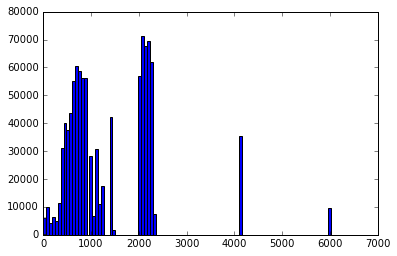

In [6]:
plt.hist(d["vehicle"], bins=100);

In [12]:
d = d[d["vehicle"]<500]
d.shape

(120495, 10)

In [18]:
len(np.unique(d["vehicle"]))
         

154

## Geo plot data and filter outliers 

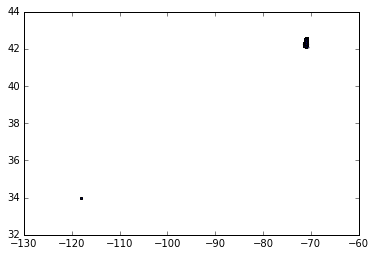

In [7]:
plt.scatter(d["longitude"], d["latitude"], s=1, alpha=0.2)

In [13]:
d=d[d["latitude"]>40]
d.shape

(120381, 10)

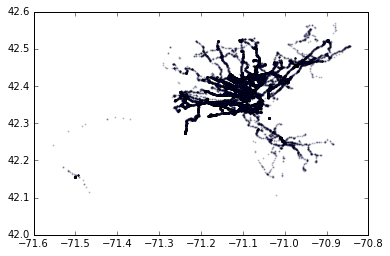

In [9]:
plt.scatter(d["longitude"], d["latitude"], s=1, alpha=0.2)

## Plot a sample

In [14]:
ds = d.sample(n=10000)

print ds.shape
if ds.shape[0]>10000:
    print "too many points to plot"
else:
    source = ColumnDataSource(data=get_data_dict(ds))
    hover = HoverTool(tooltips=[ ("pos", "(@lng, @lat)"), ("veh", "@vehicle"), ("o,e", "@odo @early")])

    xr, yr = get_ranges(ds)
    tools = get_base_tools()
    tools.append(hover)
    p = base_plot(x_range=xr, y_range=yr, tools = tools)
    p.add_tile(STAMEN_TERRAIN)
    p.circle('lngm', 'latm', source=source,  **options1)
    show(p)
    

(10000, 10)


## Some interesting observations displayed on the plot above

1.  vehicle 322, vehicle 90
-  parking lot and intersection region. Do you think that positioning precision seems more accurate when buses are moving!!
- far points in SW - weird accumulation of points at St Mary's Cemetery

In [22]:
#ds = d
#ds = d[d["vehicle"]==322]

#xr, yr = (-7.913e6, -7.911e6), (5.218e6, 5.221e6)
#ds = d[(d["longitude"]>-71.09) & (d["longitude"]<-71.07) & (d["latitude"]>42.38) & (d["latitude"]<42.40)]
#ds = ds.sample(n=10000)

ds = d[(d["longitude"]<-71.3) & (d["longitude"]<42.4)]

print "vehicles", np.unique(ds["vehicle"])
source.data= get_data_dict(ds)
bokeh.io.push_notebook()

vehicles [468 480 489]


## Get a sense on how punctuality is distributed across the city

In [23]:
output_notebook(resources=bokeh.resources.INLINE)
ds = d.sample(5000)
sourcei = ColumnDataSource(data=dict(x=ds["longitude_in_meters"], y=ds["latitude_in_meters"]))
import bokeh 
def update(earliness_min):
    dii = ds[ds["earliness_in_minutes"]>=earliness_min]
    print "min", earliness_min, "nb of datapoints", len(dii)
    sourcei.data['x'] = dii["longitude_in_meters"]
    sourcei.data['y'] = dii["latitude_in_meters"]
    bokeh.io.push_notebook()
    
xr, yr = get_ranges(ds)
pi = base_plot(x_range=xr, y_range=yr, w=400,h=200)
pi.add_tile(STAMEN_TERRAIN)
pi.circle(ds["longitude_in_meters"], ds["latitude_in_meters"], source=sourcei, **options1)
show(pi)


Loading BokehJS ...

In [24]:
interact(update, earliness_min=(-30,30))

min 1 nb of datapoints 405


## Explore what buses cover which city regions

In [25]:
output_notebook(resources=bokeh.resources.INLINE)
ds = d.sample(10000)
ds["ones"] = np.ones(len(ds))
source = ColumnDataSource(data=dict(x=ds["longitude_in_meters"], y=ds["latitude_in_meters"],veh=ds["vehicle"], ones=ds["ones"]))


# define some tools to add
TOOLS = "pan,wheel_zoom,box_zoom,box_select,lasso_select"
# Let's set up some plot options in a dict that we can re-use on multiple plots

p1 = figure(plot_width=800, plot_height=500, tools=get_base_tools())
p1.circle("x", "y", color="blue", source=source)
p1.axis.visible = False
p1.add_tile(STAMEN_TERRAIN)

p3 = figure(title="BUS#", plot_width=130, plot_height=500,  tools=get_base_tools())
p3.circle("ones", "veh",  line_color="red", fill_color=None, source=source, alpha=.2)
p3.xaxis.visible = False
p3.xgrid.grid_line_alpha = 0.

# gridplot(...) accepts nested lists of plot objects
pb = gridplot([[p1, p3]])
show(pb)

Loading BokehJS ...

## Visualize running buses

In [26]:
d["timestamp_minute"]=[":".join(i.split(".")[0].split(":")[:-1]) for i in d["timestamp_gmt"]]
mins = np.unique(d["timestamp_minute"])

In [27]:
ds = d[d["timestamp_minute"]==mins[0]]
source = ColumnDataSource(data=get_data_dict(ds))
hover = HoverTool(tooltips=[ ("pos", "(@lng, @lat)"), ("veh", "@vehicle"), ("o,e", "@odo @early")])

xr, yr = get_ranges(d)
tools = get_base_tools()
tools.append(hover)
panim = base_plot(x_range=xr, y_range=yr, tools = tools, h=400)
panim.add_tile(STAMEN_TERRAIN)
panim.circle('lngm', 'latm', source=source,  **options1)
show(panim)


In [ ]:
import time, sys
for i in mins[800:]:
    ds = d[d["timestamp_minute"]==i]
    source.data= get_data_dict(ds)
    bokeh.io.push_notebook()